In [1]:
from dask_gateway import Gateway, GatewayCluster
gateway = Gateway()

In [2]:
gateway.list_clusters()

[]

In [3]:
if len(gateway.list_clusters())>0:
    cluster = gateway.connect(gateway.list_clusters()[0].name)
else:
    cluster = GatewayCluster()
    # cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
    cluster.adapt(minimum=2, maximum=100)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:700: GatewayWarning: Adapt with `maximum=100, minimum=2` workers would exceed resource limit of 78 workers. Using `maximum=78, minimum=2` instead.
  warnings.warn(GatewayWarning(msg["msg"]))


In [4]:
gateway

Gateway<http://10.39.245.173:8000/services/dask-gateway>

In [5]:
cluster

In [6]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.da1e8c9984334b55a4b3884cc3f31bf5 Dashboard: /services/dask-gateway/clusters/prod.da1e8c9984334b55a4b3884cc3f31bf5/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
import cmip6_preprocessing

In [8]:
from dask.diagnostics import ProgressBar

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import xarray as xr
# xr.set_options(display_style='html')
import intake
%matplotlib inline

In [37]:
import mosedale as bm

ModuleNotFoundError: No module named 'oceanHeatFunctions'

In [11]:
def is_winter(month):
    '''helper function to select winter half of year (October-March)via da.sel(time=is_winter(da['time.month'])'''
    return (month >= 10) | (month <= 3)
def is_summer(month):
    '''helper function to select summer half of year (April-September) via da.sel(time=is_summer(da['time.month'])'''
    return (month >= 4) & (month <= 9)

def get_winter(da,time='time'):
    '''Restrict a DataArray to winter months (October-March) only'''
    return da.sel({time:is_winter(da['%s.month' % time])})
def get_summer(da,time='time'):
    '''Restrict a DataArray to summer months (April-September) only'''
    return da.sel({time:is_summer(da['%s.month' % time])})

def area_da(da):
    '''Get grid box area from DataArray'''
    other_dims = [d for d in da.dims if not 'latitude' in d and not 'longitude' in d]
    area = ohf.ocean_area(da.isel({d:0 for d in other_dims}),outin=True)
    area = area.drop([c for c in area.coords if not c in area.dims])
    area.attrs = {}
    return area

def weights_da(da):
    '''
    Convenience function
    Get area weights from DataArray
    Return grid box area normalized by sum over all grid boxes: area / area.sum()
    '''
    area = area_da(da)
    return area / area.sum()

def area_weighted_mean(da,area=None):
    '''Compute area-weighted mean of a DataArray (should also work for DataSets)'''
    if area is None:
        area = area_da(da)
    weights = area / area.sum()
    return (da * weights).sum(weights.dims)

def standardize(da,dims=None):
    '''
    Standardize a field by subtracting the mean and dividing by standard deviation
    If no dimensions are provided, compute mean and std.dev. over all dimensions
    '''
    if dims is None: # over all dims
        print('Standardizing over all dimensions')
        return (da - da.mean()) / da.std()
    else: # over provided dims
        print('Standardizing over these dimensions: %s' % dims)
        return (da - da.mean(dims)) / da.std(dims)

def nao_from_std(ds,varname='psl',latname='latitude',lonname='longitude',timename='timed'):
    '''
    Compute NAO index according to Mosedale et al 2005
    From "ERA5-like" grid, i.e. -90N - 90N, starting at the South Pole

    Use 5-daymeans of psl

    - take in normalized anomalies
    - difference between area-weighted averaged psl boxes (south minus north)
    '''

    box_south = ds[varname].sel({latname:slice(55,22),lonname:slice(-90,60)})
    box_north = ds[varname].sel({latname:slice(90,55),lonname:slice(-90,60)})

    box_south_mean = area_weighted_mean(box_south)
    box_north_mean = area_weighted_mean(box_north)

    nao_mose = box_south_mean - box_north_mean
    return nao_mose.rename('NAO')

def anomalies(ds,type='time',timename='time',relname='realization'):
    '''
    Compute anomalies from seasonal cycle
    1. type "time": assumes long multi-year timeseries, single realization: Climatology by averaging over dayofyear
    2. type "ensemble": assumes short single-year timeseries, multiple realizations: Climatology by ensemble mean
    '''
    if type == 'time':
        return ds.groupby('%s.dayofyear' % timename) - ds.groupby('%s.dayofyear' % timename).mean()
    elif type ==  'ensemble':
        return ds - ds.mean(relname)


def standardize_anom_season(ds,season=None,type='time',timename='time',relname='realization'):
    '''
    Compute standardized anomalies, selecting a season only if desired
    Order of operations:
    1. Compute anomalies of type "time" or type "ensemble"
    2. Standardize over time
    3. Select values from a given season
    '''

    # Winter anomalies: anomalies -> standardize -> restrict to winter
    ds_anom = anomalies(ds,type=type,timename=timename,relname=relname)
    ds_std = standardize(ds_anom,dims=timename)
    if season == 'winter':
        print('Get winter values only')
        return get_winter(ds_std,time=timename)
    elif season == 'summer':
        print('Get summer values only')
        return get_summer(ds_std,time=timename)
    elif season is None:
        print('No season selected')
        return ds_std
    else:
        print('Season %s is undefined.')
        return None

In [12]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,37
source_id,87
experiment_id,171
member_id,651
table_id,38
variable_id,710
grid_label,11
zstore,509586
dcpp_init_year,60


# MOHC

In [13]:
# cat = col.search(experiment_id='piControl', table_id='day', variable_id='psl', source_id='GFDL-CM4')
# cat = col.search(source_id=['HadGEM3-GC31-HM', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-LM', 'HadGEM3-GC31-MM'])
cat = col.search(institution_id='MOHC',table_id=['day','Oday','Eday','CFday'],variable_id=['psl','tos'])
#                  grid_label='gn')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,HadGEM3-GC31-LL,abrupt-4xCO2,r1i1p1f3,day,psl,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/abr...,NaN,20190620
1,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,r1i1p1f3,day,psl,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/1pc...,NaN,20190620
2,CMIP,MOHC,HadGEM3-GC31-LL,historical,r1i1p1f3,day,psl,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
3,CMIP,MOHC,HadGEM3-GC31-LL,historical,r4i1p1f3,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
4,CMIP,MOHC,HadGEM3-GC31-LL,historical,r2i1p1f3,day,psl,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
...,...,...,...,...,...,...,...,...,...,...,...
170,ScenarioMIP,MOHC,UKESM1-0-LL,ssp126,r6i1p1f2,day,psl,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/...,NaN,20201009
171,ScenarioMIP,MOHC,UKESM1-0-LL,ssp370,r6i1p1f2,day,psl,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/...,NaN,20201014
172,ScenarioMIP,MOHC,UKESM1-0-LL,ssp126,r5i1p1f2,day,psl,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/...,NaN,20201015
173,ScenarioMIP,MOHC,UKESM1-0-LL,ssp126,r7i1p1f2,day,psl,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/...,NaN,20201015


In [14]:
cat.df['source_id'].unique()

array(['HadGEM3-GC31-LL', 'UKESM1-0-LL', 'HadGEM3-GC31-MM'], dtype=object)

In [15]:
# cat.search(variable_id='tos',experiment_id='historical').df
# cat.search(variable_id='tos',experiment_id='historical',source_id='HadGEM3-GC31-MM').df
cat.search(variable_id='tos',experiment_id='historical',source_id='HadGEM3-GC31-LL').df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,HadGEM3-GC31-LL,historical,r4i1p1f3,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
1,CMIP,MOHC,HadGEM3-GC31-LL,historical,r2i1p1f3,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
2,CMIP,MOHC,HadGEM3-GC31-LL,historical,r1i1p1f3,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
3,CMIP,MOHC,HadGEM3-GC31-LL,historical,r3i1p1f3,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190626


In [16]:
# cat.search(variable_id='tos',experiment_id='historical').df
# cat.search(variable_id='ts',experiment_id='historical',source_id='HadGEM3-GC31-MM').df
cat.search(variable_id='ts',experiment_id='historical',source_id='HadGEM3-GC31-LL').df

/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version


In [17]:
# cat.search(variable_id='psl',experiment_id='historical').df
# cat.search(variable_id=['psl','tos','areacella','areacello'],experiment_id='historical',source_id='HadGEM3-GC31-MM').df
cat.search(variable_id=['psl','tos','areacella','areacello'],experiment_id='historical',source_id='HadGEM3-GC31-LL').df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,HadGEM3-GC31-LL,historical,r1i1p1f3,day,psl,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
1,CMIP,MOHC,HadGEM3-GC31-LL,historical,r4i1p1f3,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
2,CMIP,MOHC,HadGEM3-GC31-LL,historical,r2i1p1f3,day,psl,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
3,CMIP,MOHC,HadGEM3-GC31-LL,historical,r2i1p1f3,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
4,CMIP,MOHC,HadGEM3-GC31-LL,historical,r4i1p1f3,day,psl,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
5,CMIP,MOHC,HadGEM3-GC31-LL,historical,r1i1p1f3,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624
6,CMIP,MOHC,HadGEM3-GC31-LL,historical,r3i1p1f3,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190626
7,CMIP,MOHC,HadGEM3-GC31-LL,historical,r3i1p1f3,day,psl,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190626


In [18]:
# cat.search(variable_id='psl',experiment_id='historical').df
cat.search(variable_id=['areacella','area']).df

/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version


### get r4i1p1f3

In [19]:
# cat.search(variable_id='psl',experiment_id='historical').df
# cat_hadgem3 = cat.search(variable_id=['tos','psl'],experiment_id='historical',source_id='HadGEM3-GC31-MM',member_id='r4i1p1f3')
cat_hadgem3_ll = cat.search(variable_id=['tos','psl'],experiment_id='historical',source_id='HadGEM3-GC31-LL',member_id='r4i1p1f3')

In [20]:
# dset_dict = cat_hadgem3.to_dataset_dict(zarr_kwargs={'consolidated': True})
dset_dict = cat_hadgem3_ll.to_dataset_dict(zarr_kwargs={'consolidated': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [21]:
list(dset_dict.keys())


['CMIP.MOHC.HadGEM3-GC31-LL.historical.day.gn',
 'CMIP.MOHC.HadGEM3-GC31-LL.historical.Oday.gn']

In [22]:
# dset_dict['CMIP.MOHC.HadGEM3-GC31-MM.historical.Oday.gn']['tos']
dset_dict['CMIP.MOHC.HadGEM3-GC31-LL.historical.Oday.gn']['tos']

<xarray.DataArray 'tos' (member_id: 1, time: 59400, j: 330, i: 360)>
dask.array<broadcast_to, shape=(1, 59400, 330, 360), dtype=float32, chunksize=(1, 251, 330, 360), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 322 323 324 325 326 327 328 329
    latitude   (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-30 12:00:00
  * member_id  (member_id) <U8 'r4i1p1f3'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    long_name:      Sea Surface Temperature
    original_name:  mo: (variable_name: tos)
    standard_name:  sea_surface_temperature
    units:          degC

In [23]:
# dset_dict['CMIP.MOHC.HadGEM3-GC31-MM.historical.day.gn']['psl']
dset_dict['CMIP.MOHC.HadGEM3-GC31-LL.historical.day.gn']['psl']

,Array,Chunk
Bytes,6.57 GB,103.85 MB
Shape,"(1, 59400, 144, 192)","(1, 939, 144, 192)"
Count,129 Tasks,64 Chunks
Type,float32,numpy.ndarray


In [24]:
# areacella = xr.open_dataset('areacella_fx_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn.nc')
# areacello = xr.open_dataset('areacello_Ofx_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn.nc')

areacella = xr.open_dataset('areacella_fx_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn.nc')
areacello = xr.open_dataset('areacello_Ofx_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn.nc')

### Assemble dataset

In [25]:
# ds = xr.merge([
#     dset_dict['CMIP.MOHC.HadGEM3-GC31-MM.historical.day.gn']['psl'],
#     dset_dict['CMIP.MOHC.HadGEM3-GC31-MM.historical.Oday.gn']['tos'],
#     areacella,
#     areacello
# ]).isel(lat=slice(None,None,-1))

ds = xr.merge([
    dset_dict['CMIP.MOHC.HadGEM3-GC31-LL.historical.day.gn']['psl'],
    dset_dict['CMIP.MOHC.HadGEM3-GC31-LL.historical.Oday.gn']['tos'],
#     areacella,
#     areacello
]).isel(lat=slice(None,None,-1))

In [26]:
areacello.nbytes / 1e6

5.22996

In [27]:
years = np.unique(ds['time.year'].values)

In [28]:
years

array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
       1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
       1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 20

In [29]:
np.arange(1982,2015)

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

In [194]:
years[0]

1850

In [188]:
import os

In [189]:
os.system('rsync --help')

32512

In [106]:
ds.nbytes / 1e9, ds[['tos','psl']].nbytes / 1e9

(34.801868648, 34.79747588)

In [181]:
dsii = ds.sel(time='2000')

In [184]:
dsii.load()

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, lat: 144, lon: 192, member_id: 1, time: 360, vertices: 4)
Coordinates:
  * lat                 (lat) float64 89.38 88.12 86.88 ... -86.88 -88.12 -89.38
  * lon                 (lon) float64 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * time                (time) object 2000-01-01 12:00:00 ... 2000-12-30 12:0...
  * member_id           (member_id) <U8 'r4i1p1f3'
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
    latitude            (j, i) float32 -84.11 -84.11 -84.11 ... 50.23 50.01
    longitude           (j, i) float32 73.5 74.5 75.5 76.5 ... 72.95 72.96 72.99
Dimensions without coordinates: bnds, vertices
Data variables:
    psl                 (member_id, time, lat, lon) float32 1.033e+05 ... 9.9...
    tos                 (member_id, time, j, i) float32 nan nan nan ... nan nan
    lat_bnds            (lat, bnds) float64 88.75 90.0 87.5 ... -90.0 -88.75
    lon_bnds            (lon, bnds) float64 0.0 1.875 1.875 ... 358.1 360.0
    areacella           (lat, lon) float32 3.161e+08 3.161e+08 ... 3.161e+08
    vertices_latitude   (j, i, vertices) float32 -84.16 -84.16 ... 50.0 50.11
    vertices_longitude  (j, i, vertices) float32 73.0 74.0 74.0 ... 73.0 73.0
    areacello           (j, i) float32 nan nan nan nan nan ... nan nan nan nan

In [29]:
test = ds.isel(time=0)

In [30]:
with ProgressBar():
    test.load()

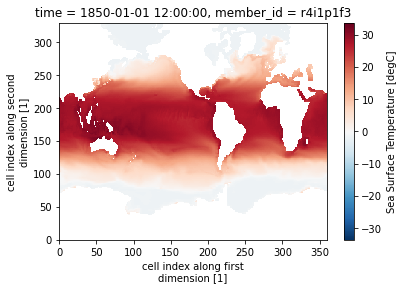

In [31]:
test['tos'].plot()

### Compute anomalies

In [32]:
ds[['psl','tos']]

,Array,Chunk
Bytes,6.57 GB,103.85 MB
Shape,"(1, 59400, 144, 192)","(1, 939, 144, 192)"
Count,193 Tasks,64 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,28.23 GB,119.28 MB
Shape,"(1, 59400, 330, 360)","(1, 251, 330, 360)"
Count,475 Tasks,237 Chunks
Type,float32,numpy.ndarray


In [33]:
# ds_anom = anomalies(ds,type='time',timename='time')
ds_anom = anomalies(ds[['psl','tos']],type='time',timename='time')

In [34]:
ds['psl']

,Array,Chunk
Bytes,6.57 GB,103.85 MB
Shape,"(1, 59400, 144, 192)","(1, 939, 144, 192)"
Count,193 Tasks,64 Chunks
Type,float32,numpy.ndarray


In [35]:
ds_anom_test = anomalies(ds['psl'].sel(time=slice('1980','2000'),lat=slice(70,50),lon=slice(0,10)),type='time',timename='time')

In [37]:
with ProgressBar():
    ds_anom_test.load()

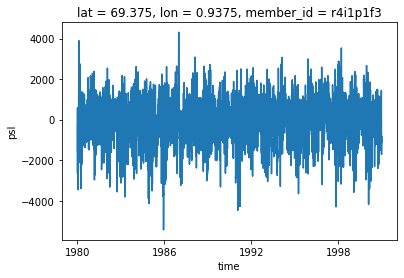

In [38]:
ds_anom_test[0,:,0,0].plot()

Standardizing over these dimensions: time


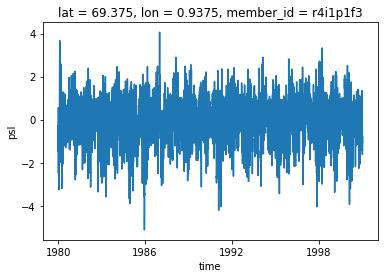

In [39]:
standardize(ds_anom_test,dims='time')[0,:,0,0].plot()

Standardizing over these dimensions: time


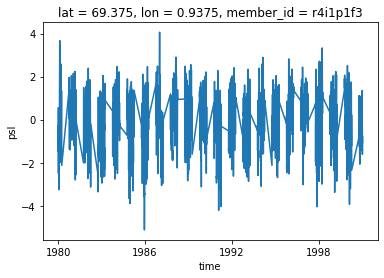

In [40]:
get_winter(standardize(ds_anom_test,dims='time'))[0,:,0,0].plot()

### standardize_anom_season, test 1: psl only, very limited region (time,lat,lon)

In [41]:
ds_anom_std_test = standardize_anom_season(ds['psl'].sel(time=slice('1980','2000'),lat=slice(70,50),lon=slice(0,10)),season='winter',type='time',timename='time')

Standardizing over these dimensions: time
Get winter values only


In [76]:
ds_anom_std_test

<xarray.Dataset>
Dimensions:    (i: 360, j: 330, lat: 16, lon: 5, member_id: 1, time: 3780)
Coordinates:
  * lat        (lat) float64 69.38 68.12 66.88 65.62 ... 54.38 53.12 51.88 50.62
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 8.438
  * time       (time) object 1980-01-01 12:00:00 ... 2000-12-30 12:00:00
  * member_id  (member_id) <U8 'r4i1p1f3'
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 322 323 324 325 326 327 328 329
    latitude   (j, i) float32 -84.11 -84.11 -84.11 -84.11 ... 50.51 50.23 50.01
    longitude  (j, i) float32 73.5 74.5 75.5 76.5 ... 72.93 72.95 72.96 72.99
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
Data variables:
    psl        (member_id, time, lat, lon) float32 -2.469 -2.504 ... 0.1831
    tos        (member_id, time, j, i) float32 nan nan nan nan ... nan nan nan

In [43]:
with ProgressBar():
    ds_anom_std_test.load()

In [77]:
ds_anom_std_test

<xarray.Dataset>
Dimensions:    (i: 360, j: 330, lat: 16, lon: 5, member_id: 1, time: 3780)
Coordinates:
  * lat        (lat) float64 69.38 68.12 66.88 65.62 ... 54.38 53.12 51.88 50.62
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 8.438
  * time       (time) object 1980-01-01 12:00:00 ... 2000-12-30 12:00:00
  * member_id  (member_id) <U8 'r4i1p1f3'
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 322 323 324 325 326 327 328 329
    latitude   (j, i) float32 -84.11 -84.11 -84.11 -84.11 ... 50.51 50.23 50.01
    longitude  (j, i) float32 73.5 74.5 75.5 76.5 ... 72.93 72.95 72.96 72.99
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
Data variables:
    psl        (member_id, time, lat, lon) float32 -2.469 -2.504 ... 0.1831
    tos        (member_id, time, j, i) float32 nan nan nan nan ... nan nan nan

### standardize_anom_season, test 2: both psl and tos, very limited region (time,lat,lon)

In [50]:
ds_anom_std_test = standardize_anom_season(ds[['psl','tos']].sel(time=slice('1980','2000'),lat=slice(70,50),lon=slice(0,10)),season='winter',type='time',timename='time')

Standardizing over these dimensions: time
Get winter values only


In [53]:
ds_anom_std_test

,Array,Chunk
Bytes,1.21 MB,320 B
Shape,"(1, 3780, 16, 5)","(1, 1, 16, 5)"
Count,61983 Tasks,3780 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.80 GB,475.20 kB
Shape,"(1, 3780, 330, 360)","(1, 1, 330, 360)"
Count,82417 Tasks,3780 Chunks
Type,float32,numpy.ndarray


In [62]:
tt = ds_anom_std_test['tos']

In [63]:
tt

,Array,Chunk
Bytes,1.80 GB,475.20 kB
Shape,"(1, 3780, 330, 360)","(1, 1, 330, 360)"
Count,82417 Tasks,3780 Chunks
Type,float32,numpy.ndarray


In [64]:
with ProgressBar():
    #     ds_anom_std_test.load()
    tt.load()

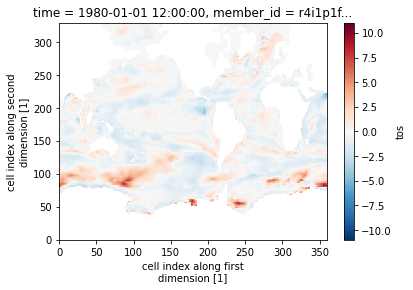

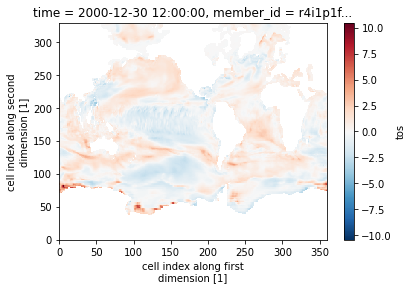

In [87]:
tt.isel(time=0).plot()
plt.figure()
tt.isel(time=-1).plot()
# tt.std('time').plot()

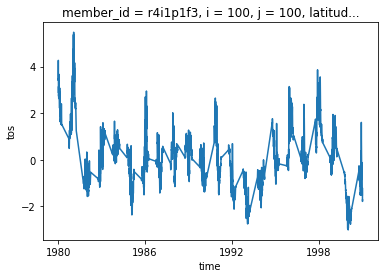

In [88]:
tt[0,:,100,100].plot()

### standardize_anom_season, test 3: both psl and tos, separately

In [91]:
ds_anom_std_test_psl = standardize_anom_season(ds['psl'],season='winter',type='time',timename='time')
ds_anom_std_test_tos = standardize_anom_season(ds['tos'],season='winter',type='time',timename='time')

Standardizing over these dimensions: time
Get winter values only
Standardizing over these dimensions: time
Get winter values only


In [93]:
ds_anom_std_test_psl

,Array,Chunk
Bytes,3.28 GB,110.59 kB
Shape,"(1, 29700, 144, 192)","(1, 1, 144, 192)"
Count,467558 Tasks,29700 Chunks
Type,float32,numpy.ndarray


In [94]:
ds_anom_std_test_tos

,Array,Chunk
Bytes,14.11 GB,475.20 kB
Shape,"(1, 29700, 330, 360)","(1, 1, 330, 360)"
Count,626708 Tasks,29700 Chunks
Type,float32,numpy.ndarray


In [ ]:
with ProgressBar():
    ds_anom_std_test_psl.load()

### Test 3: simply load ds

In [ ]:
with ProgressBar():
    ds.load()

In [111]:
dsi = ds.sel(time=slice('2000',None))

In [ ]:
dsi.load()

In [114]:
dsi = ds.isel(time=-1)

In [ ]:
dsi.load()

In [178]:
# dsi = ds['psl'].isel(time=slice(-1000,None))
# dsi = ds['tos'].isel(time=slice(-500,None))
# dsi = ds['tos'].sel(time='2000')

dsi = ds['psl'].sel(time='2000')

# dsi = ds[['psl','tos']].isel(time=-1)

In [179]:
dsi.load()#.to_netcdf

<xarray.DataArray 'psl' (member_id: 1, time: 360, lat: 144, lon: 192)>
array([[[[103260.69 , 103259.625, 103258.69 , ..., 103264.   ,
          103262.875, 103261.75 ],
         [103145.625, 103141.875, 103138.25 , ..., 103157.25 ,
          103153.31 , 103149.44 ],
         [103043.81 , 103035.44 , 103027.19 , ..., 103069.06 ,
          103060.625, 103052.125],
         ...,
         [ 98032.5  ,  98043.06 ,  98055.44 , ...,  98003.125,
           98013.44 ,  98023.19 ],
         [ 98052.94 ,  98060.75 ,  98069.25 , ...,  98031.25 ,
           98038.25 ,  98045.44 ],
         [ 98134.75 ,  98138.5  ,  98142.44 , ...,  98124.69 ,
           98127.81 ,  98131.125]],

        [[103182.69 , 103182.375, 103182.06 , ..., 103184.31 ,
          103183.625, 103183.19 ],
         [103028.125, 103027.125, 103026.375, ..., 103032.81 ,
          103030.94 , 103029.375],
         [102855.56 , 102853.94 , 102852.94 , ..., 102863.81 ,
          102860.5  , 102857.75 ],
...
         [ 99919.625,  99926.75 ,  99936.75 , ...,  99897.81 ,
           99905.   ,  99913.06 ],
         [100024.81 , 100032.56 , 100042.19 , ..., 100000.81 ,
          100008.75 , 100017.5  ],
         [100126.875, 100129.06 , 100128.625, ..., 100121.25 ,
          100122.94 , 100124.19 ]],

        [[101508.44 , 101516.25 , 101523.94 , ..., 101484.56 ,
          101492.56 , 101500.5  ],
         [101687.06 , 101710.69 , 101734.31 , ..., 101614.   ,
          101638.44 , 101662.69 ],
         [101839.81 , 101879.69 , 101919.81 , ..., 101717.75 ,
          101758.875, 101799.125],
         ...,
         [ 99680.19 ,  99686.375,  99692.44 , ...,  99664.81 ,
           99670.25 ,  99674.5  ],
         [ 99745.5  ,  99749.625,  99755.   , ...,  99733.19 ,
           99737.56 ,  99741.25 ],
         [ 99660.   ,  99660.81 ,  99661.31 , ...,  99657.44 ,
           99658.25 ,  99658.75 ]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 89.38 88.12 86.88 85.62 ... -86.88 -88.12 -89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * time       (time) object 2000-01-01 12:00:00 ... 2000-12-30 12:00:00
  * member_id  (member_id) <U8 'r4i1p1f3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Sea Level Pressure
    long_name:      Sea Level Pressure
    original_name:  mo: (stash: m01s16i222, lbproc: 128)
    standard_name:  air_pressure_at_mean_sea_level
    units:          Pa

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

In [ ]:
dsi.to_netcdf('psl_2000_2014.nc',compute=True)

In [ ]:
1

In [140]:
dsi = ds['tos'].isel(time=-1)

In [141]:
dsi.load()

<xarray.DataArray 'tos' (member_id: 1, j: 330, i: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    time       object 2014-12-30 12:00:00
  * member_id  (member_id) <U8 'r4i1p1f3'
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 322 323 324 325 326 327 328 329
    latitude   (j, i) float32 -84.11 -84.11 -84.11 -84.11 ... 50.51 50.23 50.01
    longitude  (j, i) float32 73.5 74.5 75.5 76.5 ... 72.93 72.95 72.96 72.99
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    long_name:      Sea Surface Temperature
    original_name:  mo: (variable_name: tos)
    standard_name:  sea_surface_temperature
    units:          degC

In [142]:
dsi.to_netcdf('test.nc')

In [ ]:
# Works:
dsi = ds['tos'].isel(time=-1)
dsi = ds['psl'].isel(time=-1)

psl: 1000 last timesteps
tos: 400 last timesteps

### Compute winter standardized anomalies

In [ ]:
#ds_std_anom = standardize_anom_season(ds,season='winter',type='time',timename='time')
ds_std_anom = standardize_anom_season(ds[['psl','tos']],season='winter',type='time',timename='time')

In [89]:
ds_std_anom

NameError: name 'ds_std_anom' is not defined

In [38]:
1 

1

In [39]:
print('Computing NAO')
# nao = nao_from_std(ds_std_anom,timename='time',latname='lat',lonname='lon')#.load()
box_south = ds_std_anom['psl'].sel({'lat':slice(55,22),'lon':slice(-90,60)})
box_north = ds_std_anom['psl'].sel({'lat':slice(90,55),'lon':slice(-90,60)})

area_south = ds['areacella'].sel({'lat':slice(55,22),'lon':slice(-90,60)})
area_north = ds['areacella'].sel({'lat':slice(90,55),'lon':slice(-90,60)})
weights_south = area_south / area_south.sum()
weights_north = area_north / area_north.sum()

box_south_mean = (box_south * weights_south).sum(weights_south.dims)
box_north_mean = (box_north * weights_north).sum(weights_north.dims)

nao_mose = box_south_mean - box_north_mean

Computing NAO


In [90]:
nao_mose

NameError: name 'nao_mose' is not defined

In [ ]:
with ProgressBar():
    nao_mose.load()

In [ ]:
# Compute patterns
print('Computing pattern correlations')
pattern_nao = xs.pearson_r(nao_mose,ds_std_anom['psl'].fillna(0.).load(),dim=['time']).rename('r_NAO_psl')
pattern_sst = xs.pearson_r(nao_mose,ds_std_anom['sst'].fillna(0.).load(),dim=['time']).rename('r_NAO_sst')
# Compute tripole index
print('Computing pattern tripole')
tripole = (ds['sst'] * pattern_sst.sel(longitude=slice(-95,-10),latitude=slice(70,0))).sum(['latitude','longitude']).rename('Tripole')

In [121]:
sst_test = dset_dict['CMIP.MOHC.HadGEM3-GC31-MM.historical.Oday.gn']['tos'].isel(member_id=0,time=-1)
psl_test = dset_dict['CMIP.MOHC.HadGEM3-GC31-MM.historical.day.gn']['psl'].isel(member_id=0,time=-1)

test = xr.merge([sst_test,psl_test])

In [125]:
with ProgressBar():
    test.load()

In [ ]:
import mat

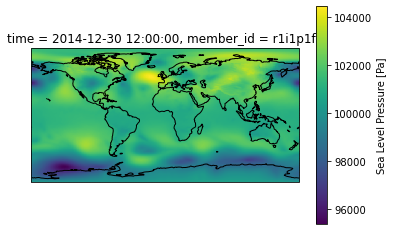

In [138]:
# test['psl'].plot()
test['psl'].plot(subplot_kws={'projection':ccrs.PlateCarree()})
plt.gca().coastlines()

In [133]:
import cartopy.crs as ccrs

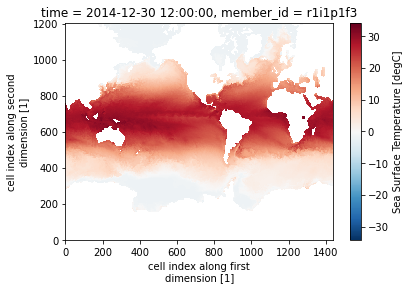

In [143]:
test['tos'].plot()

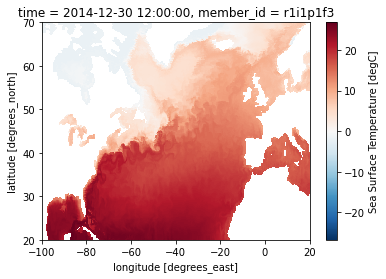

In [163]:
test['tos'].where(lambda x: (x['latitude'] > 20) & (x['latitude']< 70) & (x['longitude'] > -100) & (x['longitude'] < 20)).plot(x='longitude',y='latitude',xlim=[-100,20],ylim=[20,70])#.sel(latitude=slice(20,70))#.plot()

In [ ]:
test['tos'].plot(subplot_kws={'projection':ccrs.PlateCarree()})#(x='longitude',y='latitude')
# test['tos'].plot(x='longitude',y='latitude',subplot_kws={'projection':ccrs.PlateCarree()})

In [164]:
1

1